In [22]:
from OF_trigger import *

sampling_frequency = 3906250


template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"
# Parameters

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

In [34]:
path = "/ceph/dwong/trigger_samples/noise_traces/brownian_noise_traces.zst"
loaded_traces = load_traces_from_zstd(path, n_traces=n_sets)

In [35]:
loaded_traces.shape

(100, 54, 32768)

In [36]:
from tools import *

In [5]:
from numpy.fft import rfft, fft, ifft, fftfreq, rfftfreq
import numpy as np

def calculate_psd(traces, sampling_frequency=1.0):
    """Return the PSD of an n-dimensional array, assuming that we want the PSD of the last axis.
    Originally taken from https://github.com/spice-herald/QETpy/blob/master/qetpy/core/_noise.py
    
    Parameters
    ----------
    traces : array_like
        Array to calculate PSD of.
    sampling_frequency : float, optional
        Sample rate of the data being taken, assumed to be in units of Hz.
            
    Returns
    -------
    f : ndarray
        Array of sample frequencies
    psd : ndarray
        Power spectral density of traces. If traces are in units of A, then the PSD is in units of A^2/Hz.
        One can plot the psd with
            plt.loglog(f,psd)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('PSD (A$^2$/Hz)')
            plt.show()
        
    """
    
    # calculate normalization for correct units
    norm = sampling_frequency * traces.shape[-1]

    # if folded_over = True, we calculate the Fourier Transform for only the positive frequencies
    if len(traces.shape)==1:
        psd = (np.abs(rfft(traces))**2.0)/norm
    else:
        psd = np.mean(np.abs(rfft(traces))**2.0, axis=0)/norm

    # multiply the necessary frequencies by two (zeroth frequency should be the same, as
    # should the last frequency when x.shape[-1] is odd)
    psd[1:traces.shape[-1]//2+1 - (traces.shape[-1]+1)%2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)

    return f, psd

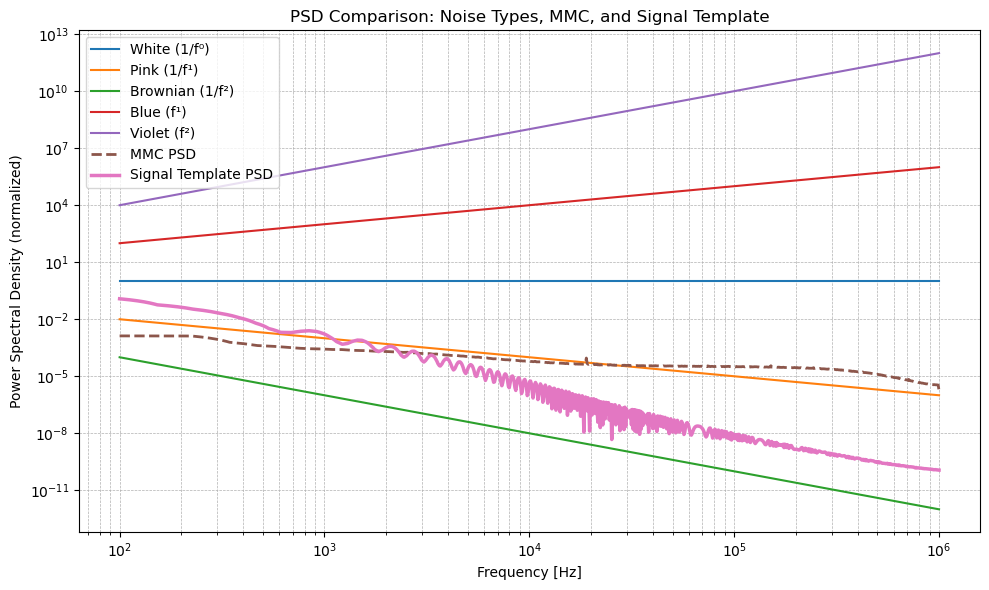

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.fft import rfft, rfftfreq
import os

# Your PSD function
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm

    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)
    return f, psd

# Frequency axis for consistent comparison
frequencies = np.logspace(2, 6, 1000)  # 1.25 Hz to 10,000 Hz

# Define noise color PSDs
psd_white = np.ones_like(frequencies)
psd_pink = 1 / frequencies
psd_brownian = 1 / frequencies**2
psd_blue = frequencies
psd_violet = frequencies**2

# Load MMC PSD
mmc_path = "../templates/noise_psd_from_MMC.npy"
if os.path.exists(mmc_path):
    mmc_psd = np.load(mmc_path)
    if len(mmc_psd) != len(frequencies):
        original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
        mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)
else:
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")

# Load signal template and compute PSD
template_path = "../templates/template_K_alpha_tight.npy"
if os.path.exists(template_path):
    signal = np.load(template_path)
    sampling_rate = 2500000.0
    signal_freqs, signal_psd = calculate_psd(signal, sampling_frequency=sampling_rate)

    # Normalize signal PSD and interpolate to match plotting frequencies
    signal_psd /= np.max(signal_psd)  # normalize for visibility
    signal_interp = interp1d(signal_freqs[1:], signal_psd[1:], bounds_error=False, fill_value=0)
    signal_psd_resampled = signal_interp(frequencies)
else:
    raise FileNotFoundError(f"Signal template not found at: {template_path}")

# Plot all
plt.figure(figsize=(10, 6))
plt.loglog(frequencies, psd_white, label='White (1/f⁰)')
plt.loglog(frequencies, psd_pink, label='Pink (1/f¹)')
plt.loglog(frequencies, psd_brownian, label='Brownian (1/f²)')
plt.loglog(frequencies, psd_blue, label='Blue (f¹)')
plt.loglog(frequencies, psd_violet, label='Violet (f²)')
plt.loglog(frequencies, mmc_psd, label='MMC PSD', linestyle='--', linewidth=2.0)
plt.loglog(frequencies, signal_psd_resampled, label='Signal Template PSD', linewidth=2.5)

plt.title("PSD Comparison: Noise Types, MMC, and Signal Template")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density (normalized)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


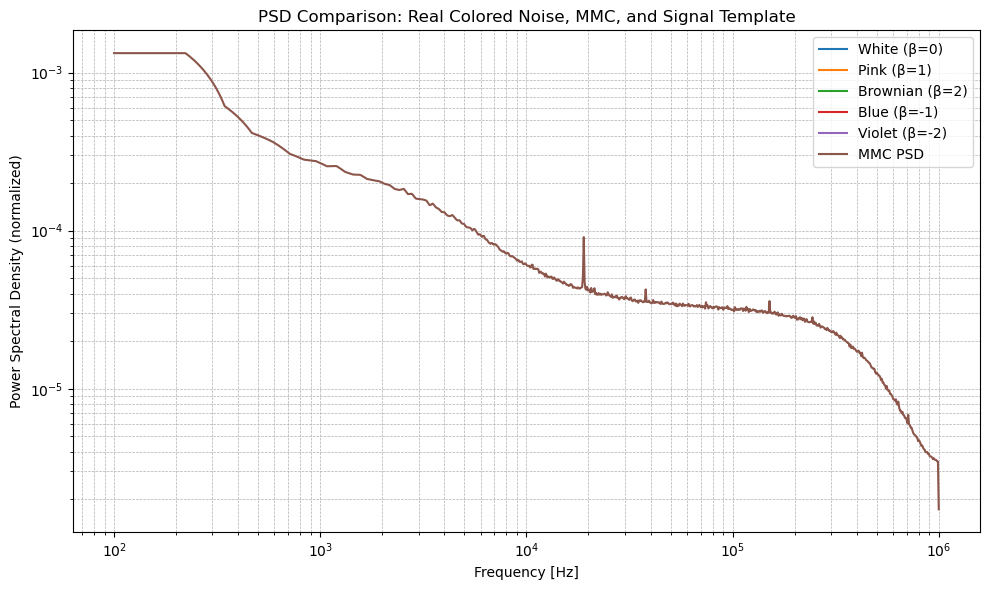

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.fft import rfft, rfftfreq
import os

# --- PSD Calculation ---
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm
    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)
    return f, psd

# --- Colored Noise Generator ---
def generate_colored_noise(beta, size, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    white_noise = rng.normal(size=size)
    white_fft = np.fft.rfft(white_noise)
    f = np.fft.rfftfreq(size)
    f[0] = 1e-6  # Avoid divide-by-zero

    shaped_fft = white_fft / f**(beta / 2.0)
    colored_noise = np.fft.irfft(shaped_fft)
    return colored_noise

# --- Parameters ---
n_samples = 2**16
sampling_rate = 1.0  # Relative units (can be changed)
frequencies = np.logspace(2, 6, 1000)  # For plotting: 100 Hz to 1 MHz

# --- Generate Colored Noise PSDs ---
noise_colors = {
    'White (β=0)': 0,
    'Pink (β=1)': 1,
    'Brownian (β=2)': 2,
    'Blue (β=-1)': -1,
    'Violet (β=-2)': -2
}
psds = {}

for name, beta in noise_colors.items():
    trace = generate_colored_noise(beta, n_samples)
    f_colored, psd_colored = calculate_psd(trace, sampling_frequency=sampling_rate)
    interp_psd = interp1d(f_colored[1:], psd_colored[1:], bounds_error=False, fill_value=0)
    psds[name] = interp_psd(frequencies)

# --- Load MMC PSD ---
mmc_path = "../../templates/noise_psd_from_MMC.npy"
if os.path.exists(mmc_path):
    mmc_psd = np.load(mmc_path)
    if len(mmc_psd) != len(frequencies):
        original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
        mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)
    psds["MMC PSD"] = mmc_psd
else:
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")


# --- Plot ---
plt.figure(figsize=(10, 6))

for name, psd_vals in psds.items():
    plt.loglog(frequencies, psd_vals, label=name)

plt.title("PSD Comparison: Real Colored Noise, MMC, and Signal Template")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density (normalized)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


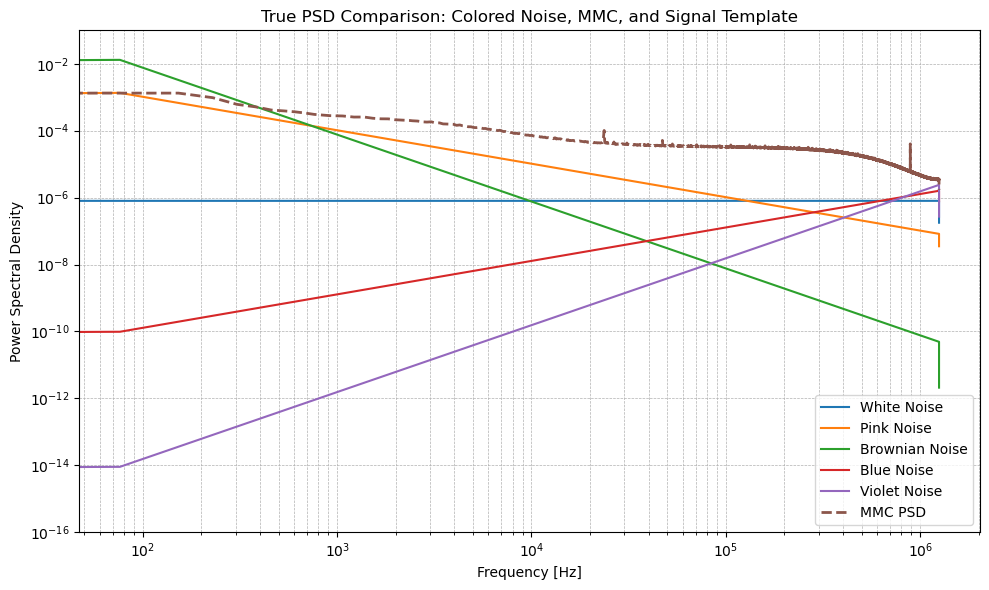

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq, irfft
from scipy.interpolate import interp1d
import os

# === PSD Calculation Function ===
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm

    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)
    return f, psd

# === Noise Spectra Definitions ===
def noise_spectrum(f, noise_type):
    f = np.asarray(f)
    if noise_type == 'white':
        return np.ones_like(f)
    elif noise_type == 'blue':
        return f
    elif noise_type == 'violet':
        return f**2
    elif noise_type == 'brownian':
        return 1. / np.where(f == 0, np.inf, f**2)
    elif noise_type == 'pink':
        return 1. / np.where(f == 0, np.inf, f)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")

def spectrum_normalization(f, noise_type):
    if noise_type == 'white':
        return 1. / (np.max(f) - np.min(f))
    elif noise_type == 'blue':
        return 2. / (np.max(f)**2 - np.min(f)**2)
    elif noise_type == 'violet':
        return 3. / (np.max(f)**3 - np.min(f)**3)
    elif noise_type == 'brownian':
        return 1. / (1. / np.sort(f)[1] - 1. / np.max(f))
    elif noise_type == 'pink':
        return 1. / (np.log(np.max(f)) - np.log(np.sort(f)[1]))
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")

# === Parameters ===
sampling_rate = 2_500_000.0
N = 32768
psd_area = 1.0
frequencies = rfftfreq(N, d=1.0/sampling_rate)

# === Generate and Store PSDs for Color Noises ===
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']
color_psds = {}

for noise_type in noise_types:
    spec = noise_spectrum(frequencies, noise_type)
    norm_factor = 0.5 * psd_area * spectrum_normalization(frequencies, noise_type) * sampling_rate * N
    psd = norm_factor * spec
    psd_sqrt = np.sqrt(psd)

    # Random complex spectrum with uniform phase
    phi = np.random.uniform(0, 2*np.pi, len(psd))
    Xf = psd_sqrt * np.exp(1j * phi)

    # Inverse FFT to get time-domain noise
    trace = irfft(Xf)

    # Compute PSD from time-domain noise
    f_psd, psd_est = calculate_psd(trace, sampling_rate)
    color_psds[noise_type] = (f_psd, psd_est)

# === Load MMC PSD ===
mmc_path = "../../templates/noise_psd_from_MMC.npy"
if os.path.exists(mmc_path):
    mmc_psd = np.load(mmc_path)
    if len(mmc_psd) != len(frequencies):
        original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
        mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)
else:
    raise FileNotFoundError(f"MMC PSD not found at: {mmc_path}")

# === Load Signal Template and PSD ===
template_path = "../../templates/template_K_alpha_tight.npy"
if os.path.exists(template_path):
    signal = np.load(template_path)
    signal_freqs, signal_psd = calculate_psd(signal, sampling_frequency=sampling_rate)
    signal_psd /= np.max(signal_psd)
    signal_interp = interp1d(signal_freqs[1:], signal_psd[1:], bounds_error=False, fill_value=0)
    signal_psd_resampled = signal_interp(frequencies)
else:
    raise FileNotFoundError(f"Signal template not found at: {template_path}")

# === Plot ===
plt.figure(figsize=(10, 6))

for name, (f, psd) in color_psds.items():
    plt.loglog(f, psd, label=f'{name.capitalize()} Noise')

plt.loglog(frequencies, mmc_psd, label='MMC PSD', linestyle='--', linewidth=2.0)
#plt.loglog(frequencies, signal_psd_resampled, label='Signal Template PSD', linewidth=2.5)

plt.title("True PSD Comparison: Colored Noise, MMC, and Signal Template")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(1e-16, 1e-1)

plt.tight_layout()
plt.show()
